# TMDB Movies data set analysis

IMDB is a Internet movie data base, for more information, click on https://en.wikipedia.org/wiki/IMDb / https://www.imdb.com/. 
In this project, we are considering data provided by IMDB. 

We are analyzing below points based on IMDB data.
 1. get average profit percentage and average budget of each genre
 2. get top 5 artist along with their mean profit percentage in each genre
 3. get top 5 production company along with their mean profit percentage in each genre
 4. get top 5 director along with their mean profit percentage in each genre


#### Consideration/Assumptions for the analysis

1. A movie can/will have multiple "genre, artist or production house". different "genre/artist/production house" can have  different effect on success/failure of a movie. When we say success or failure, we are talking about profit percentage.

    - In this analysis, we have not considered
     - percentage contribution of each genre of the movie in success/failure of the movie. 
     - percentage contribution of each artist of the movie in success/failure of the movie.
     - percentage contribution of each production house in success/failure of the movie. 
 
    - We have considered, if "genre/artist/production house" is part of a movie which is either successfull or failure. Profit percentage of the movie affects data used for analyis of each "genre/artist/production house" of the movie.

2. We have considered movies whose budget is atleast USD: 50,000 and revenue is atleast USD: 5,000.

3. While doing analysis on a genre, we have considered
    - Artist who has done atleast 4 movies which has the genre under investigation.
    - production house, which has produced atleast 2 movies which has the genre under investigation.
    - director who has directed atleast 2 movies which has the genre under investigation.

#### This analysis will be helpfull 
 - For an artist to consider director and production company while making new movie
 - For a director to approach successfull production comany and artists based on genres he/she is directing
 - For a production company to approach successfull artists and director based on genre

<b>Note: It is very important to understand mentioned consideration/assumptions while making use of the analysed data</b> 

In [1]:
#Import section
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [2]:
#Data reading and Wrangling

#Read data from CSV file
tmdb_movies = pd.read_csv('tmdb-movies.csv')

#Verify if there are any abnormal rows of data for columns which we are concerned
tmdb_movies.count()

id                      10866
imdb_id                 10856
popularity              10866
budget                  10866
revenue                 10866
original_title          10866
cast                    10790
homepage                 2936
director                10822
tagline                  8042
keywords                 9373
overview                10862
runtime                 10866
genres                  10843
production_companies     9836
release_date            10866
vote_count              10866
vote_average            10866
release_year            10866
budget_adj              10866
revenue_adj             10866
dtype: int64

### Data Wrangling
- Remove data which doesn't has any of the following information, since our analysis depends on these variables.
 - imdb_id 
 - cast
 - genre
 - production_companies
 - director 
- Remove movies which has release before 1990 in order to keep our analysis to recent movies

In [3]:
#Clean up data
'''
We can notice 
total row count is 10866, 
cast count is 10790, 
genres count is 10843, 
budget_adj count is 10866
revenue_adj count is 10866
imdb_id is 10856
production_companies is 9836
director is 10822
'''

# Remove rows which doesn't has imdb_id
tmdb_movies = tmdb_movies[tmdb_movies['imdb_id'].notnull()]

#find if all IMDB_id's are unique
entries = []
for entry in tmdb_movies['imdb_id']:
    if entry not in entries:
        entries.append(entry)
    else:
        print("Duplicate IMDB ID")
        print(entry)

#We can notice we have one duplicate entry with imdb_id: tt0411951. Remove this row of data which is repeated
tmdb_movies = tmdb_movies.drop_duplicates(subset=["imdb_id"], keep='first', inplace=False)

# Remove rows which doesn't has cast
tmdb_movies = tmdb_movies[tmdb_movies['cast'].notnull()]

# Remove rows which doesn't has genres
tmdb_movies = tmdb_movies[tmdb_movies['genres'].notnull()]

# Remove rows which doesn't has production_companies
tmdb_movies = tmdb_movies[tmdb_movies['production_companies'].notnull()]

# Remove rows which doesn't has director
tmdb_movies = tmdb_movies[tmdb_movies['director'].notnull()]

# Keep only movies data which has release after 1990
tmdb_movies = tmdb_movies[tmdb_movies['release_year'] > 1989]

Duplicate IMDB ID
tt0411951


 - verify if we see any abnormalities in budget_adj and revenue_adj and correct the data. 

In [4]:
#Describe budget_adj
tmdb_movies['budget_adj'].describe()

"""
We have atleast one record which has zero budget. 
On verifying further we can notice multiple movies whose budget is market Zero. 
Cross verifying few of these movies in wikipedia tells us these are actually not Zero budget movies.
There is some fishy about these tis
At this point we assume, TMDB doesn't have budget information of these movies, so they are marked as Zero budget movies. 
So, we will remove these movies from the dataframe based on our assumption. 
Along with these we will remove movies whose budget is less than $50,000.
Rest all stats looks fine in budget_adj
"""

tmdb_movies = tmdb_movies[tmdb_movies['budget_adj'] > 50000]

#Describe revenue_adj
tmdb_movies['revenue_adj'].describe()

'''
We can notice, revenue of atleast one movie is Zero. 
On cross verifying these movies box office revenue in Wikipedia, we can notice the revenue is not zero.
So, we are going to remove these records from dataframe, assuming IMDB doesn't has revenue records of these movies
Along with these we will remove movies whose Revenue is less than $5,000.
'''
tmdb_movies = tmdb_movies[tmdb_movies['revenue_adj'] > 5000]

 - create two new rows 
  - profit = revenue - budget
  - profit_percentage = (revenue - budget) * 100 / budget


In [5]:
#Create two new rows for profit and profit_percentage

tmdb_movies["profit"] = tmdb_movies["revenue_adj"] -tmdb_movies["budget_adj"]
tmdb_movies["profit_percentage"] = ((tmdb_movies["revenue_adj"] - tmdb_movies["budget_adj"]) * 100) / tmdb_movies["budget_adj"]

'''We will end data Wrangling process, and start data analysis from next section. Below is the final data count after data wrangling'''
tmdb_movies.count()

id                      3163
imdb_id                 3163
popularity              3163
budget                  3163
revenue                 3163
original_title          3163
cast                    3163
homepage                1330
director                3163
tagline                 2946
keywords                3050
overview                3163
runtime                 3163
genres                  3163
production_companies    3163
release_date            3163
vote_count              3163
vote_average            3163
release_year            3163
budget_adj              3163
revenue_adj             3163
profit                  3163
profit_percentage       3163
dtype: int64

##Data Analysis

Write the required functions for our analysis
 - split_by_pipe
 - display_graph
 - genre_graph_details
 - get_list_genre_dict
 - top5_per_genre_graph

In [6]:
'''
Function to split by pipe and create rows for each, for example for genres "Thriller|Crime|Drama" , 
we will have three rows of data with same value in all the fields except genre, which will have "Thriller", "Crime", "Drama" 
in diffrent rows.
'''
def split_by_pipe(df, column_name):
    header_names = list(df)
    header_list_of_list = []
    result_df = pd.DataFrame(columns=header_names)
    for index, row in df.iterrows():
        list_by_pipe = row[column_name].split("|")
        for item in list_by_pipe:
            row_data = []
            for header in header_names:
                if header != column_name:
                    row_data.append(row[header])
                else:
                    row_data.append(item)
            result_df.loc[len(result_df)] = row_data     
    return result_df


'''
This function takes three arguments:
data: dataframe,
column_name: column name on which it operates
min_movies: minimum number of moves done on genre

The function will generate and return
1. DataFrame with column name 
    A. genre - this will have genre name
    B. column_name - this will have name of (artist/director/productionHouse)
    C. profit_percentage - Mean profit_percentage of 5 popular person/entity for each genre
2. Top 5 popular person/entity(artist/ production house, depnding on value passed in "column_name) for each genre
Mean profit_percentage of 5 popular person/entity for each genre

'''
def get_list_genre_dict(data, column_name, min_movies):
    result_genre_profit = pd.DataFrame()
    result_genre_name_list = []
    df_group = data.groupby("genres")
    for genre, genre_group in df_group:        
        genre_name_list = {}
        genre_profit_list = []
        artists  = genre_group.groupby(column_name)["profit_percentage"]
        artist_name_list = []
        artist_profit_list = []
        genre_list = []
        for artist, profitpercentage in artists:            
            if profitpercentage.count() >= min_movies:                
                artist_name_list.append(artist)
                artist_profit_list.append(profitpercentage.mean())
                genre_list.append(genre[:3])
        df = pd.DataFrame()
        df['genre'] = genre_list
        df[column_name] = artist_name_list
        df["profit_percentage"] = artist_profit_list
        df = df.sort_values(by=['profit_percentage'], ascending=False, inplace=False, kind='quicksort', na_position='last')
        df = df[:5]        
        genre_name_list[genre] = df[column_name].tolist()
        genre_profit_list = df["profit_percentage"].tolist()
        #If we have 5 records, append to the result
        if df["profit_percentage"].count() == 5:
            result_genre_profit = result_genre_profit.append(df,ignore_index=True)
            result_genre_name_list.append(genre_name_list)
    return result_genre_profit, result_genre_name_list

tmdb_split_by_genere = split_by_pipe(tmdb_movies, "genres")

Create 3 dataframe which has
 - tmdb_split_by_genere: single genre name in genres column 
 - tmdb_split_by_genere_artist: single genre name in genres column and single artist name in cast column
 - tmdb_split_by_genere_production: single genre name in genres column and single ProductionHouse name in production_companies column


In [7]:
#split by pipe on genre to cerate additional rows of data for each genre in genres
tmdb_split_by_genere = split_by_pipe(tmdb_movies, "genres")

#split by pipe on genre to cerate additional rows of data for each genre in genres
tmdb_split_by_genere_artist = split_by_pipe(tmdb_split_by_genere, "cast")

#split by pipe on production_companies to cerate additional rows of data for each genre in genres
tmdb_split_by_genere_production = split_by_pipe(tmdb_split_by_genere, "production_companies")

### Analysis on profit percentage

In [8]:
# genrate list of success, profit_percentage, loss_percentage
movie_success = tmdb_split_by_genere["profit_percentage"] > 0
movies_with_profit = [x for x in tmdb_split_by_genere["profit_percentage"] if x > 0 and x < 1001]
movies_with_more_profit = [x for x in tmdb_split_by_genere["profit_percentage"] if x > 1000]
Movies_with_loss = [x for x in tmdb_split_by_genere["profit_percentage"] if x < 0]
tmdb_split_by_genere["genere_short_name"] = tmdb_split_by_genere["genres"].apply(lambda x: x[:3]).tolist()


Text(0,0.5,'Number of Movies')

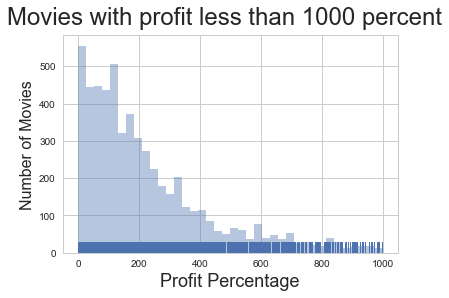

In [9]:
#Genrate graph on movies with profit less than 1000 percent
fig = sns.distplot(movies_with_profit, kde=False, rug=True);
fig.figure.suptitle("Movies with profit less than 1000 percent", fontsize = 24)
plt.xlabel('Profit Percentage', fontsize=18)
plt.ylabel('Number of Movies', fontsize=16)


Text(0,0.5,'Number of Movies')

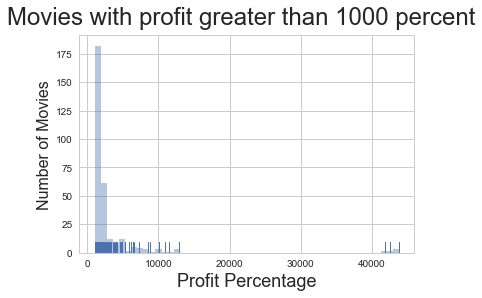

In [10]:
#Genrate graph on movies with profit greater than 1000 percent
fig = sns.distplot(movies_with_more_profit, kde=False, rug=True);
fig.figure.suptitle("Movies with profit greater than 1000 percent", fontsize = 24)
plt.xlabel('Profit Percentage', fontsize=18)
plt.ylabel('Number of Movies', fontsize=16)

Text(0,0.5,'Number of Movies')

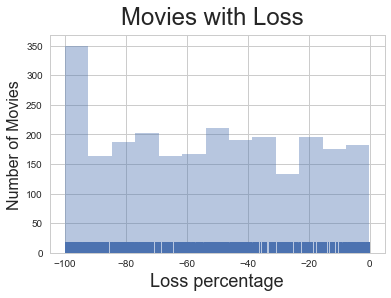

In [12]:
#Genrate graph on movies with loss
fig = sns.distplot(Movies_with_loss, kde=False, rug=True);
fig.figure.suptitle("Movies with Loss", fontsize = 24)
plt.xlabel('Loss percentage', fontsize=18)
plt.ylabel('Number of Movies', fontsize=16)

#### Observation:

1. Number of movies which are in profit are significantly higher compared to number of movies which are in loss.
2. "Movies which are in loss" is having uniform distribution of "loss percentage".
3. "Movies with profit" is postively skewed with considerable number of movies have got profit of more than 1000%, which is mind blowing. 

## <a style="color:blue">Objective 1</a>
- Get mean profit percentage and mean budget of each genre and display it in graph 

In [13]:
genre_short_full_names = pd.DataFrame()
genre_short_full_names["ShortName"] = tmdb_split_by_genere["genere_short_name"].unique()
genre_short_full_names["FullName"] = tmdb_split_by_genere["genres"].unique()
genre_short_full_names

,ShortName,FullName
0,Act,Action
1,Adv,Adventure
2,Sci,Science Fiction
3,Thr,Thriller
4,Fan,Fantasy
5,Cri,Crime
6,Wes,Western
7,Dra,Drama
8,Fam,Family
9,Ani,Animation


<b>We will be using above mentioned Genre short names in the rest of this analysis</b>

In [14]:
#get mean budget and profit percentage for each genre
genere_group = tmdb_split_by_genere.groupby("genere_short_name")["budget_adj", "profit_percentage"].mean()
genre_profit = genere_group["profit_percentage"].sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
genre_budget = genere_group["budget_adj"].sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

Text(0,0.5,'Profit Percentage')

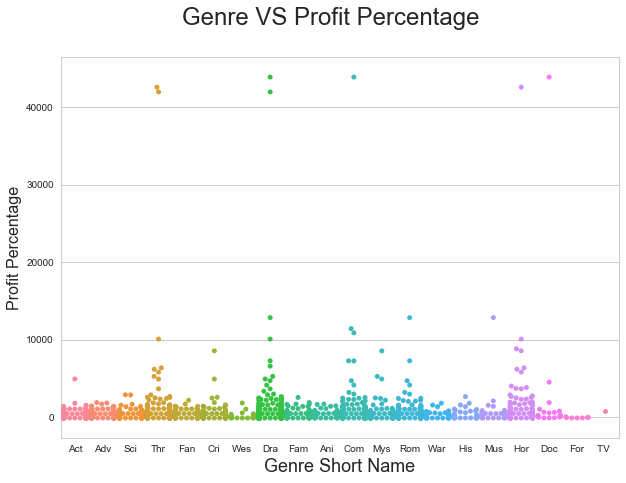

In [15]:
#Generate graph for each movie profit percentage based on Genre

plt.figure(figsize=(10, 7))
fig = sns.swarmplot("genere_short_name", "profit_percentage", data=tmdb_split_by_genere)
fig.figure.suptitle("Genre VS Profit Percentage", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Profit Percentage', fontsize=16)

Text(0,0.5,'Profit Percentage Avearage')

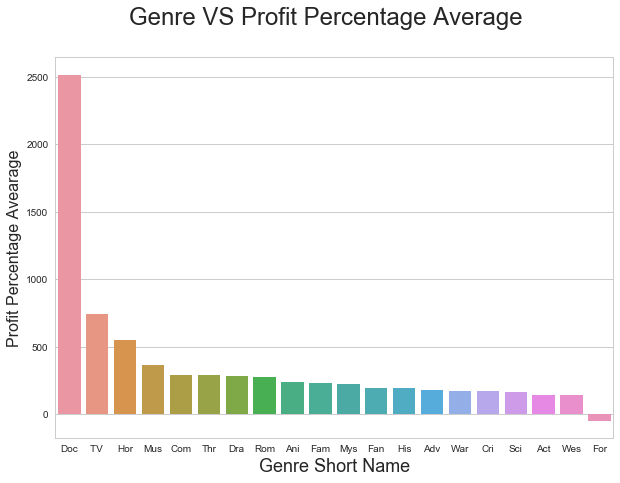

In [16]:
#Generate graph for each movie profit percentage based on Genre
df_mpp = pd.DataFrame()
df_mpp["genere_short_name"] = genre_profit.index.values.tolist()
df_mpp["profit_percentage"] = genre_profit.tolist()

plt.figure(figsize=(10, 7))
fig = sns.barplot("genere_short_name", "profit_percentage", data=df_mpp)
fig.figure.suptitle("Genre VS Profit Percentage Average", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Profit Percentage Avearage', fontsize=16)

Text(0,0.5,'Budget Avearage')

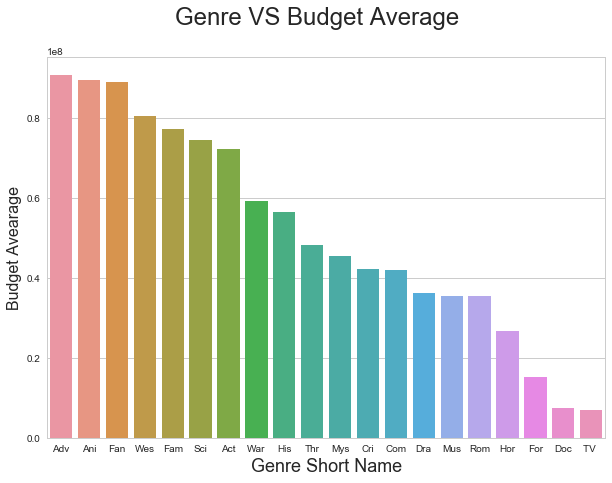

In [17]:
#Generate graph for each movie profit percentage based on Genre
df_mb = pd.DataFrame()
df_mb["genere_short_name"] = genre_budget.index.values.tolist()
df_mb["budget_adj"] = genre_budget.tolist()

plt.figure(figsize=(10, 7))
fig = sns.barplot("genere_short_name", "budget_adj", data=df_mb)
fig.figure.suptitle("Genre VS Budget Average", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Budget Avearage', fontsize=16)

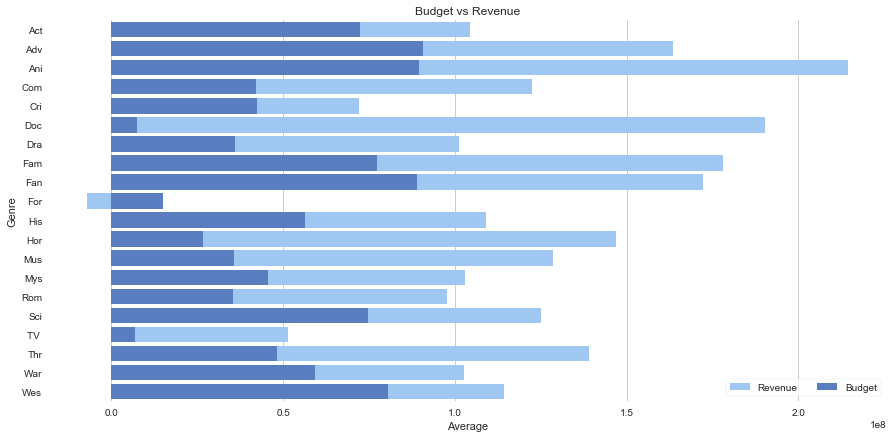

In [18]:
genere_group
df_pr = pd.DataFrame()
df_pr["genere_short_name"] = genere_group.index.values.tolist()
df_pr["profit_percentage"] = (genere_group["budget_adj"] * genere_group["profit_percentage"] /100).tolist()
df_pr["budget_adj"] = genere_group["budget_adj"].tolist()

sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 7))

# Plot the profit Percentage
sns.set_color_codes("pastel")
sns.barplot(x="profit_percentage", y="genere_short_name", data=df_pr,
            label="Revenue", color="b")

# Plot the Budget
sns.set_color_codes("muted")
sns.barplot(x="budget_adj", y="genere_short_name", data=df_pr,
            label="Budget", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(title="Budget vs Revenue", ylabel="Genre",
       xlabel="Average")
sns.despine(left=True, bottom=True)


#### Observation

In genral we have noticed
1. All movie genre is in profit except "Foriegn" genre.
2. Genre's with less budget has seen more profit percentage barring "Foriegn" genre.
3. Movies with more budget has got decent profit percentage, when we convert percentage to actual dollar, it can be huge considering the budget.

## <a style="color:blue">Objective 2</a>
    - Get top 5 artist along with their mean profit percentage in each genre


Top 5 artists of Genre, who has done atleast 4 movies in the genre
---------------------------
Action: ['Sandra Bullock', 'Liv Tyler', 'Elijah Wood', 'Orlando Bloom', 'Viggo Mortensen']
Adventure: ['Robert Pattinson', 'Peter Facinelli', 'Ray Romano', 'Taylor Lautner', 'Liv Tyler']
Animation: ['Ray Romano', 'Denis Leary', 'Robin Williams', 'Steve Carell', 'Tom Hanks']
Comedy: ['Tom Wilkinson', 'Rowan Atkinson', 'Maggie Smith', 'Jason Lee', 'Joe Pesci']
Crime: ['Danny Glover', 'Sandra Bullock', 'Tobin Bell', 'Costas Mandylor', 'Joe Pesci']
Drama: ['John Hannah', 'Jason Lee', 'Sally Field', 'Jeremy Northam', 'Colin Firth']
Family: ["Catherine O'Hara", 'Ray Romano', 'Denis Leary', 'Daniel Radcliffe', 'Rupert Grint']
Fantasy: ['Robert Pattinson', 'Elijah Wood', 'Peter Facinelli', 'Kristen Stewart', 'Taylor Lautner']
Horror: ['Tobin Bell', 'Betsy Russell', 'Costas Mandylor', 'Sarah Michelle Gellar', 'David Koechner']
Mystery: ['Danny Glover', 'Sarah Michelle Gellar', 'Courteney Cox', 'David 

Text(0,0.5,'Profit Percentage')

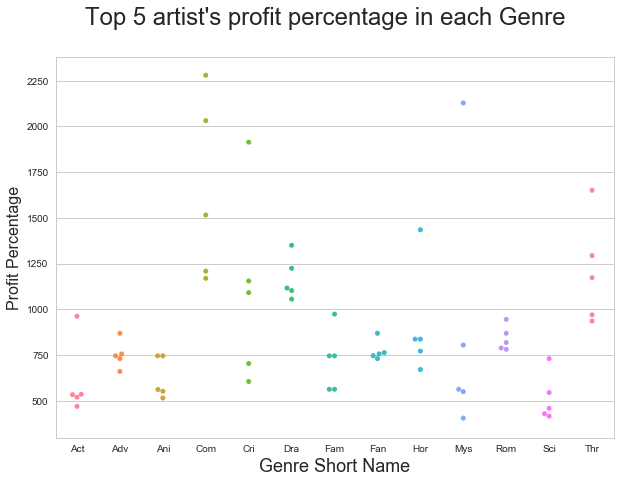

In [19]:
#Get top 5 artist for each genre who has performed atleast 4 movies in that particular genre
tmdb_split_by_genere_artist.count()
genre_profit, artist = get_list_genre_dict(tmdb_split_by_genere_artist, "cast", 4)

# display top 5 artists in each genre 
print("Top 5 artists of Genre, who has done atleast 4 movies in the genre")
print("---------------------------")
for g in artist:
    for key, value in g.items():
        print("{}: {}".format(key, value))
    
print("---------------------------")

#Display graph for top 5 artists
plt.figure(figsize=(10, 7))
fig = sns.swarmplot("genre", "profit_percentage", data=genre_profit)
fig.figure.suptitle("Top 5 artist's profit percentage in each Genre", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Profit Percentage', fontsize=16)


#### Observation

1. There are 13 genres for which we could able to find top 5 artists with the considerations and limitations we had.
2. Action, Adventure, Animation, Romance and Fantasy genre's top 5 artist has similar profit pecentage (average) and rest of the genre's top 5 artists has scattered profit percentage (average)

## <a style="color:blue">Objective 3</a>
    - get top 5 production company along with their mean profit percentage in each genre

Top 5 production companies of Genre, who has produced atleast 2 movies in the genre
---------------------------
Action: ['The Saul Zaentz Company', 'Tig Productions', 'Kasdan Pictures', 'Bold Films', 'Lucasfilm']
Adventure: ['Imprint Entertainment', 'Maverick Films', 'The Saul Zaentz Company', 'Temple Hill Entertainment', 'Majestic Films International']
Animation: ['Illumination Entertainment', 'Universal Pictures', 'Walt Disney Animation Australia', 'Bagdasarian Productions', 'Blue Sky Studios']
Comedy: ['Channel Four Films', 'Playtone Productions', 'Gold Circle Films', 'Silver Screen Partners IV', 'Tiger Aspect Productions']
Crime: ['Evolution Entertainment', 'Twisted Pictures', 'Channel Four Films', 'A Band Apart', 'Palace Pictures']
Drama: ['Sherwood Pictures', 'Playtone Productions', 'Provident Films', 'Affirm Films', 'Gold Circle Films']
Family: ['Hughes Entertainment', 'Illumination Entertainment', 'Heyday Films', 'Walt Disney Animation Australia', 'Silver Screen Partners IV']
F

Text(0,0.5,'Profit Percentage')

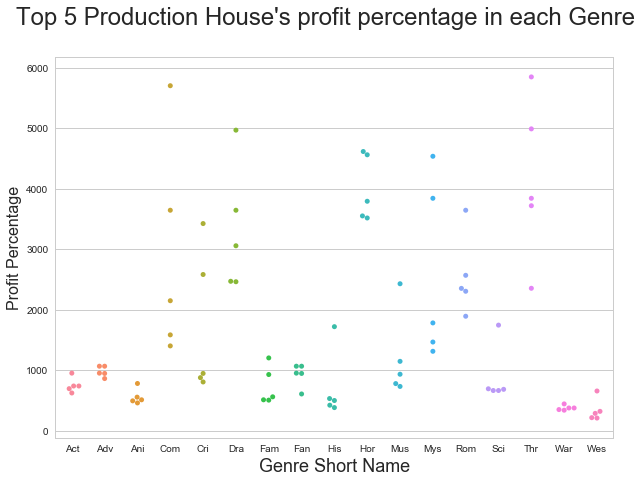

In [20]:
#Get top 5 production companies for each genre who has produced atleast 2 movies in that particular genre
genre_profit, production_company = get_list_genre_dict(tmdb_split_by_genere_production, "production_companies", 2)

# display top 5 artists in each genre 
print("Top 5 production companies of Genre, who has produced atleast 2 movies in the genre")
print("---------------------------")
for g in production_company:
    for key, value in g.items():
        print("{}: {}".format(key, value))
print("---------------------------")

#Display graph for top 5 Production Company
plt.figure(figsize=(10, 7))
fig = sns.swarmplot("genre", "profit_percentage", data=genre_profit)
fig.figure.suptitle("Top 5 Production House's profit percentage in each Genre", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Profit Percentage', fontsize=16)

#### Observation

1. There are 17 genres for which we could able to find top 5 "Production Company" with the considerations and limitations we had.
2. Action, Adventure, Animation, War and Western genre's top 5 "Production Company" has similar profit pecentage (average).
3. Top "Production House" of Thriller and Comedy genre has got maximum profit percentage. 

## <a style="color:blue">Objective4</a>
    - get top 5 director along with their mean profit percentage in each genre

Top 5 Director of Genre, who has done atleast 4 movies in the genre
---------------------------
Action: ['Peter Jackson', 'Wes Ball', 'Jay Roach', 'George Lucas', 'James Cameron']
Adventure: ['Kevin Costner', 'Chris Columbus', 'Ron Clements|John Musker', 'Chris Weitz', 'Carlos Saldanha']
Animation: ['Pierre Coffin|Chris Renaud', 'Ron Clements|John Musker', 'Carlos Saldanha', 'Gary Trousdale|Kirk Wise', 'Eric Darnell|Tom McGrath']
Comedy: ['Jared Hess', 'Peter Cattaneo', 'Jason Reitman', 'Chris Columbus', 'John Madden']
Crime: ['James Wan', 'Darren Lynn Bousman', 'Quentin Tarantino', 'Neil Jordan', 'Jay Roach']
Drama: ['John Carney', 'Alex Kendrick', 'Kevin Smith', 'Darren Aronofsky', 'Rick Famuyiwa']
Family: ['Chris Columbus', 'Pierre Coffin|Chris Renaud', 'Ron Clements|John Musker', 'Carlos Saldanha', 'David Yates']
Fantasy: ['Ron Clements|John Musker', 'Chuck Russell', 'Chris Weitz', 'Gary Trousdale|Kirk Wise', 'Bill Condon']
History: ['Steven Spielberg', 'John Madden', 'Jean-Marc Va

Text(0,0.5,'Profit Percentage')

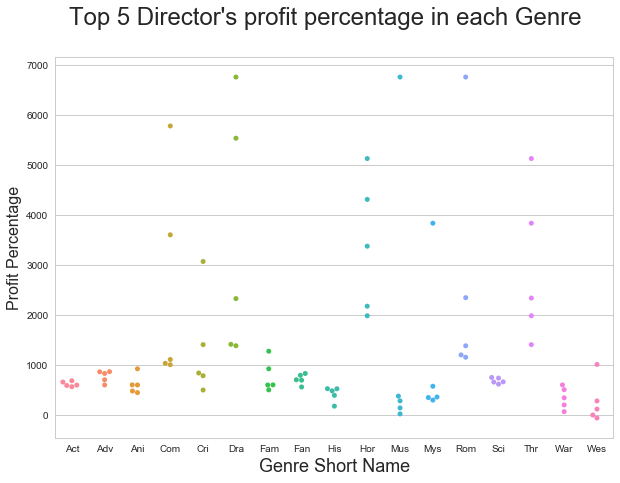

In [21]:
#Get top 5 director for each genre who has directed atleast 2 movies in that particular genre
tmdb_split_by_genere_artist.count()
genre_profit, director = get_list_genre_dict(tmdb_split_by_genere, "director", 2)

# display top 5 Director in each genre 
print("Top 5 Director of Genre, who has done atleast 4 movies in the genre")
print("---------------------------")
for g in director:
    for key, value in g.items():
        print("{}: {}".format(key, value))
print("---------------------------")

#Display graph for top 5 Director
plt.figure(figsize=(10, 7))
fig = sns.swarmplot("genre", "profit_percentage", data=genre_profit)
fig.figure.suptitle("Top 5 Director's profit percentage in each Genre", fontsize = 24)
plt.xlabel('Genre Short Name', fontsize=18)
plt.ylabel('Profit Percentage', fontsize=16)

#### Observation

1. There are 17 genres for which we could able to find top 5 "Director" with the considerations and limitations we had.
2. Action, Adventure, Animation, and Science Fiction genre's top 5 "Production Company" has similar profit pecentage (average).


## Conclusion

- <h3>Findings</h3>
 - Major portion of our investigation is to find top 5 artist/director/production house which could influence the profit of a movie of each genre. We could able to find
      - Top artists of 13 genres
      - Top Productions House of 17 genres
      - Top Directors of 17 genres
 - Top 5 Artist, Production House and Director's of Action, Adventure and Animation genre's seems to have almost same profit percentage. So, these genre's success might depend on lot other aspects too.
 - We have noticed more number of movies are in profit compared to loss, this is really good for movie industry and people working in movie industry. All the genre's except Foriegn genre are in profit in general. 
 - Genres which has less revenue seems to have more profit percentage baring few genre's, this needs to be investigated further for more findings. 
 
- <h3>Limitations</h3>
 - For quite a lot of movie's, Revenue and profit information in the dataset has value as 0, this made us to exclude these movies from our investiagtion. 
 - We do not have data to find contribution of individual "Artist/Production House" in the success/failure of the movie. Which could have provided real potential they possess in terms of profit genration.
 - The data set we investigated is for the movie details available in TMDB, which might not have all language/country movies. 
 


## References:
 - Stackoverflow: https://stackoverflow.com
 - Wikipedia: https://www.wikipedia.org
 - Seaborn: https://seaborn.pydata.org